# Naive Bayes
In this notebook we will create a simple spam classifier from a scratch using Naive Bayes theorem and then we will compare it with *scikit-learn* based classifier. Although Naive Bayes model requires pretty strong assumption to be met (the features of a dataset must be independent), it performs quite well in real life situations and is easy to build and train.

The first step should be importing the necessary libraries and loading a dataset into the DataFrame.

In [1]:
import os
import string
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

file_name = os.path.join(os.getcwd(), 'data\spam.csv')
df = pd.read_csv(file_name, engine='python')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We should remove three last columns because they don't contain any data. Also it's a good idea to rename the first two columns so they will describe content more accurately.

In [2]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Now we will provide basic exploratory data analysis to describe and visualize our dataset.

In [3]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

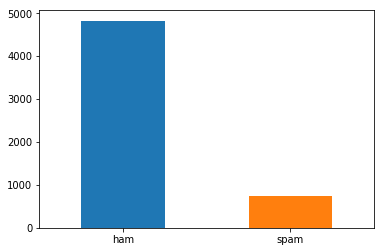

In [5]:
df['label'].value_counts().plot(kind='bar', rot=0)

In [6]:
def show_wordcloud(label):
    text = ' '.join(df[df['label'] == label]['message'].tolist())
    stopwords = set(STOPWORDS)
    color = 'Reds' if label == 'spam' else 'Greens'
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white', colormap=color).generate(text)
    
    plt.figure(figsize=[10, 8])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

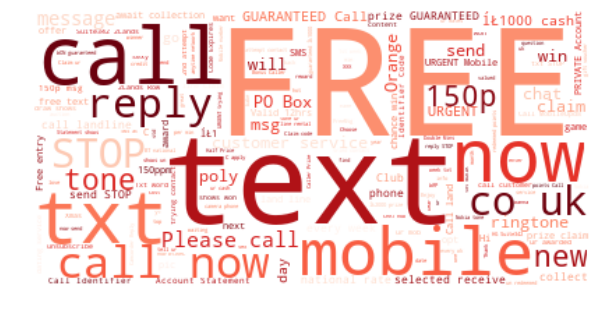

In [7]:
show_wordcloud('spam')

Spam messages tend to have the most frequent words associated with advertisements, sales and calls.

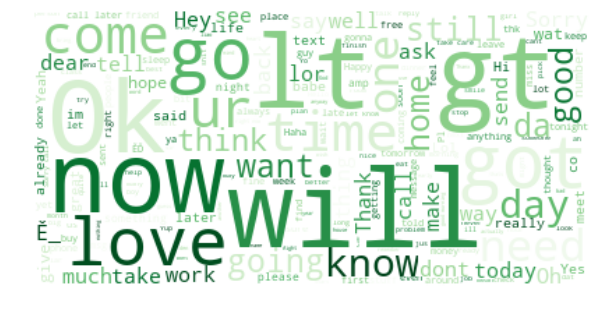

In [8]:
show_wordcloud('ham')

On the other hand the most frequent words within normal messages are slang words and acronyms or words connected with some positive emotions.

In the next step we need to map labels to numerical values, lowercase messages, remove punctuation, tokenize the words and finally remove stop words.

In [9]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df['message'] = df['message'].str.lower()
df['message'] = df['message'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
df['message'] = df['message'].str.split()
df['message'] = df['message'].apply(lambda row: [word for word in row if word not in STOPWORDS])
df.head()

,label,message
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, goes, usf, lives, around, t..."


Now we need to split the dataset for training set (80%) and testing set (20%).

In [10]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)

When we have our training set, we can create bags of words both for ham and spam messages.

In [11]:
def create_bow(label):
    bow = {}
    for word_list in train_set[train_set['label'] == label]['message']:
        for word in word_list:
            if word in bow:
                bow[word] += 1
            else:
                bow[word] = 1
    return bow

ham_bow = create_bow(0)
spam_bow = create_bow(1)

ham_unique_words = len(ham_bow.keys())
ham_total_words = sum(ham_bow.values())
spam_unique_words = len(spam_bow.keys())
spam_total_words = sum(spam_bow.values())

The probability of message belonging to the appropriate class if it contains a given word can be calculated using Naive Bayes theorem:

\begin{equation}
P(C|W_{i}) = \frac{P(W_{i}|C)\cdot P(C)}{P(W_{i}|C_{1})\cdot P(C_{1}) + P(W_{i}|C_{2})\cdot P(C_{2})}
\end{equation}

In the first place we need to calculate the prior probability that a message belongs to the given class.

In [12]:
def p_class(label):
    return len(train_set[train_set['label'] == label])/len(train_set)

The next step is defining the function that we can use to calculate the likelihood that given word appears in either spam or ham message. We will apply Laplace smoothing to avoid the situation when the given word doesn't appear in the bag of words resulting in likelihood being equal 0:

\begin{equation}
P(W_{i}|C) = \frac{count(W_{i}, C) + 1}{count(C) + |V| +1}
\end{equation}

In [13]:
def p_word_class(word, label):
    if label == 0:
        likelihood = (ham_bow.get(word, 0) + 1)/(ham_total_words + ham_unique_words + 1)
    else:
        likelihood = (spam_bow.get(word, 0) + 1)/(spam_total_words + spam_unique_words + 1)
    return likelihood

Now we can create a function that calculates posterior probability, based on the first equation.

In [14]:
def p_class_word(word, label):
    p_word_spam = p_word_class(word, 1)
    p_word_ham = p_word_class(word, 0)
    p_spam = p_class(1)
    p_ham = p_class(0)
    if label == 0:
        probability = (p_word_ham * p_ham)/(p_word_spam * p_spam + p_word_ham * p_ham)
    else:
        probability = (p_word_spam * p_spam)/(p_word_spam * p_spam + p_word_ham * p_ham)
    return probability

Finally we are ready to combine single probabilities so we can consider all the words in the message. To do so we will use the following equation:

\begin{equation}
P(C|W) = \frac{P(C|W_{1})\cdot P(C|W_{2})\cdots P(C|W_{n})}{P(C|W_{1})\cdot P(C|W_{2})\cdots P(C|W_{n}) + (1 - P(C|W_{1}))(1 - P(C|W_{2}))\cdots (1 - P(C|W_{n}))}
\end{equation}


In [15]:
def p_class_words(words, label):
    probabilities = []
    for word in words:
        probabilities.append(p_class_word(word, label))
    probabilities_not = [1 - x for x in probabilities]
    total_probability = np.product(probabilities)/(np.product(probabilities) + np.product(probabilities_not))
    return total_probability

We will treat our implemented algorithm with the testing set to make predictions.

In [16]:
y_pred = []
y_test = test_set['label'].values

for word_list in test_set['message']:
    probability = p_class_words(word_list, 1)
    y_pred.append(probability)

y_pred = np.asarray(y_pred)

The last step is the evaluation of the created classifier. To measure a performance of the model we will plot build a confusion matrix and plot ROC curve with AUC score.

Accuracy: 91.66%
Precision: 95.54%
Recall: 71.99%


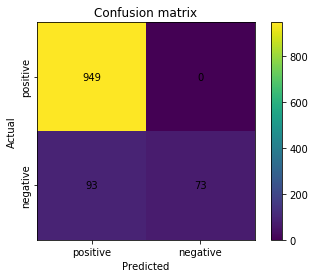

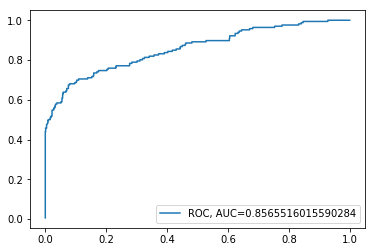

In [17]:
def build_cnf(y_test, y_pred):
    # Changing the continuous values of probabilities into discrete values of classes
    y_pred_disc = np.copy(y_pred)
    y_pred_disc[y_pred_disc > 0.5] = 1
    y_pred_disc[y_pred_disc <= 0.5] = 0
    
    cnf = metrics.confusion_matrix(y_test, y_pred_disc)
    accuracy = metrics.accuracy_score(y_test, y_pred_disc)
    precision = metrics.precision_score(y_test, y_pred_disc, average='macro')
    recall = metrics.recall_score(y_test, y_pred_disc, average='macro')
    
    print('Accuracy: ' + str(round(accuracy*100, 2)) + '%')
    print('Precision: ' + str(round(precision*100, 2)) + '%')
    print('Recall: ' + str(round(recall*100, 2)) + '%')
    
    heatmap = plt.imshow(cnf)
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 2, 1))
    ax.set_yticks(np.arange(0, 2, 1))
    ax.set_xticklabels(['positive', 'negative'])
    ax.set_yticklabels(['positive', 'negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion matrix')
    
    for i in range(np.shape(cnf)[0]):
        for j in range(np.shape(cnf)[1]):
            text = ax.text(j, i, cnf[i, j], ha='center', va='center')
    
    plt.setp(ax.get_yticklabels(), rotation=90, ha='center', rotation_mode='anchor')
    plt.colorbar(heatmap)
    plt.show()
    
def plot_roc(y_test, y_pred):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="ROC, AUC="+str(auc))
    plt.legend()
    plt.show()

build_cnf(y_test, y_pred)
plot_roc(y_test, y_pred)

As we can see the performance of implemented model is quite poor. Despite of accuracy reaching over 90%, recall and AUC score are fairly low which means that our model labeled a reasonable amount of spam messages as non-spam. Now let's create the classifier based on *scikit-learn* libraries and compare its performance with previously built model.

Accuracy: 97.76%
Precision: 95.28%
Recall: 95.95%


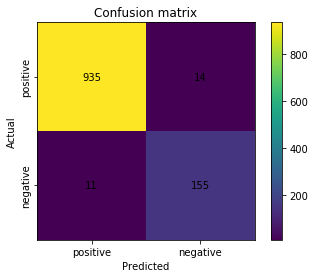

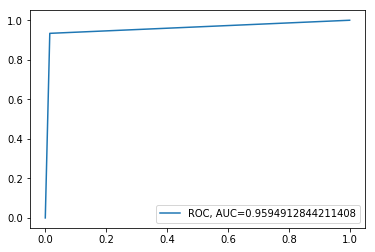

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

df_copy = df.copy()
df_copy['message'] = df['message'].apply(lambda word_list: ' '.join(word_list))

count_vect = CountVectorizer()
counts = count_vect.fit_transform(df_copy['message'])

X_train, X_test, Y_train, Y_test = train_test_split(counts, df_copy['label'], test_size=0.2, random_state=0)

model = MultinomialNB().fit(X_train, Y_train)
predictions = model.predict(X_test)

build_cnf(Y_test, predictions)
plot_roc(Y_test, predictions)

As expected *scikit-learn* model performs much better, reaching over 95% of accuracy and recall. Also AUC score is close to 1.